# U.S. Religion Census: Religious Congregations and Membership Study, 2010 (County File)

In [1]:
from probplots import plot_dists_pps

from collections import OrderedDict
from imp import reload
import pdb
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import SVG, display

from hud_geo_conversions import read_zips_to_fips
from map_maker import draw_county_data_svg
from utilities import (display_cb, is_outlier_instance, is_outlier_val,
                       boxcox_standardize, read_fips_codes)
from probplots import ProbPlots, plot_dists_pps

from ajpp import read_ajpp_geo, read_ajpp_pop
import jdata
from jewish_county_data import read_jdata_counties, clean_jdata_county
from acs import read_acs_israeli_ancestry
from religion_census import read_all_denoms, read_cb, read_judaic_denoms




pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

SEED = 42
random.seed(SEED)

In [2]:
DATA_DIR    = '../Data/'

REL_DIR  = ''.join([DATA_DIR, 'Religion/'])
RELCEN_CB_FP  = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File-CB.TXT'])
RELCEN_FP = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File.DTA'])



In [3]:
from imp import reload
import religion_census
reload(religion_census)
from religion_census import read_judaic_denoms, read_all_denoms
df_cb = read_cb(RELCEN_CB_FP)
df = read_judaic_denoms(RELCEN_FP)
display_cb(df_cb.head())
df.head()

,DESCRIPTION
VAR,
FIPS,FIPS code
STCODE,State code
CNTYCODE,County code
CNTYNAME,County name
STABBR,State abbreviation


,State,County,Tot_Cngs,Tot_No,Tot_Ra,ConsvJud_Cngs,ConsvJud_No,ConsvJud_Ra,OrthJudCngs,OrthJud_No,OrthJud_Ra,ReconJud_Cngs,ReconJud_No,ReconJud_Ra,RefJud_Cngs,RefJud_No,RefJud_Ra,UnionMessJews_Cngs
FIPS,,,,,,,,,,,,,,,,,,
01001,AL,Autauga County,106.000,36938.000,676.879,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
01003,AL,Baldwin County,271.000,96918.000,531.740,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
01005,AL,Barbour County,89.000,15101.000,549.990,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
01007,AL,Bibb County,81.000,11430.000,498.800,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
01009,AL,Blount County,156.000,37352.000,651.620,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [4]:
def select_cols(df, suffix, exclude):
    return df.select(
        lambda x: x.endswith(suffix) and x not in exclude, axis=1)

In [5]:
df['Tot_Jews'] = select_cols(df, '_No', ['Tot_No']).sum(1)
df['Tot_JewCngs'] = select_cols(df, 'Cngs', ['Tot_Cngs']).sum(1)
df_no = df.select(lambda x: '_No' in x, axis=1)
df_cngs = df.select(lambda x: '_Cngs' in x, axis=1)


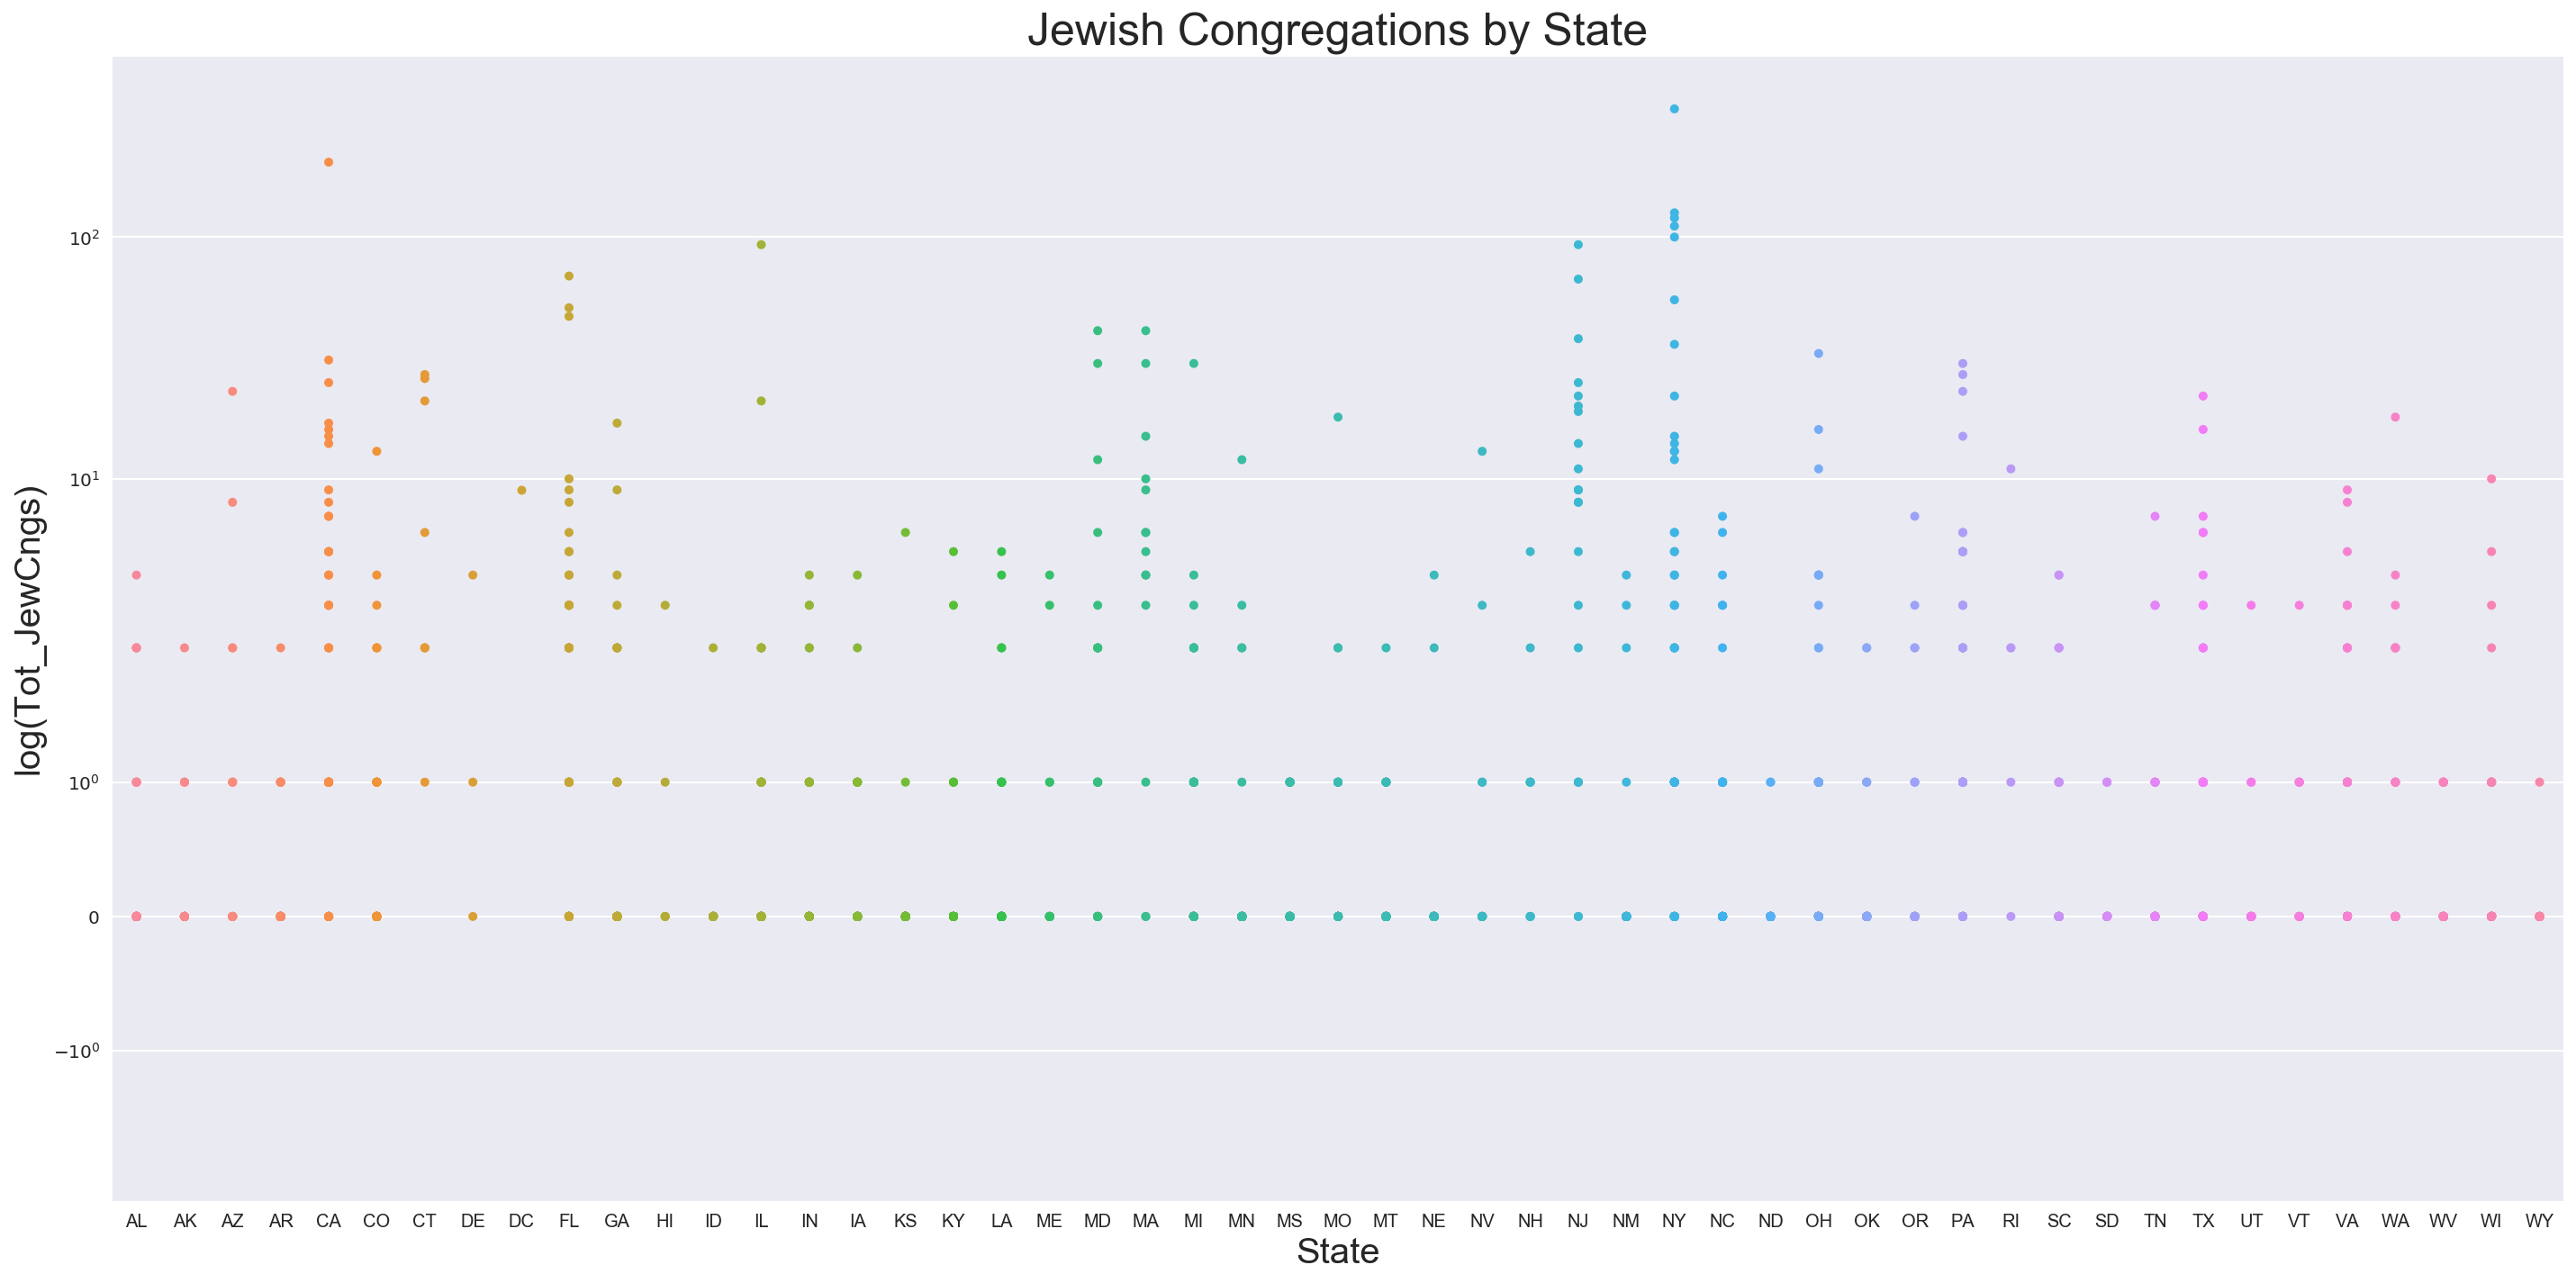

In [6]:
y = 'Tot_JewCngs'
x = 'State'
data = df
plt.figure(figsize=(20, 10))
ax = sns.stripplot(x=x, y=y, data=data)
ax.set_yscale('symlog')
ax.set_xlabel(x, size=20)
ax.set_ylabel('log('+y+')', size=20)
plt.title('Jewish Congregations by State', size=25)

plt.tight_layout()

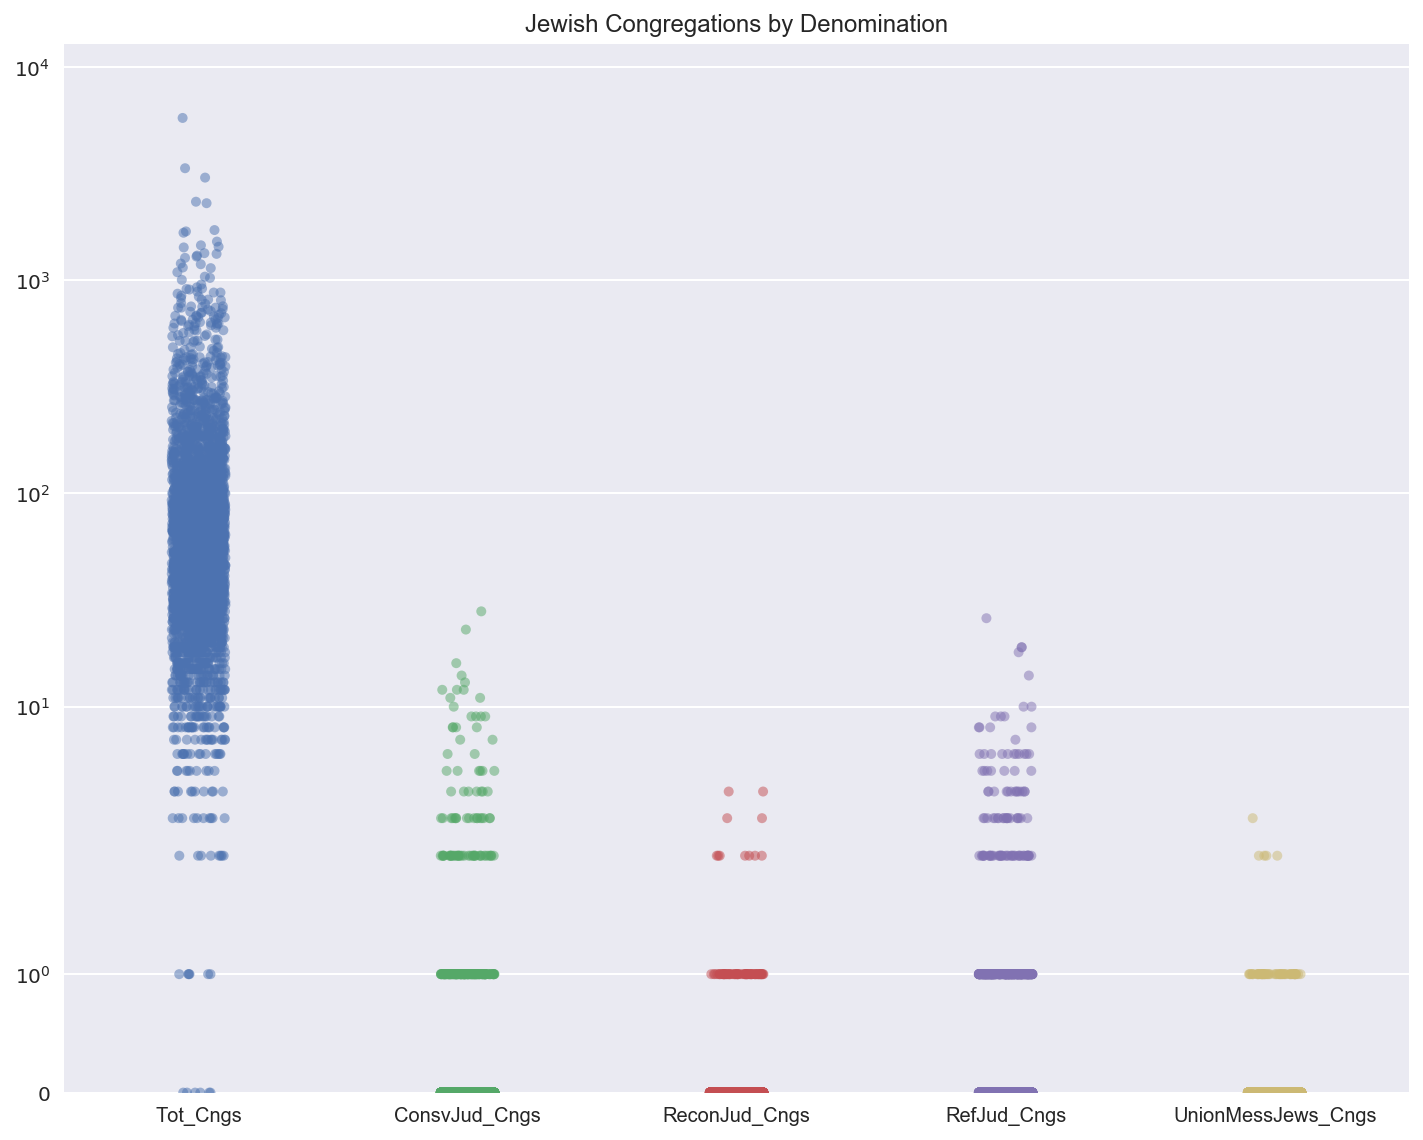

In [7]:
plt.figure(figsize=(10, 8))
ax = sns.stripplot(data=df_cngs, jitter=True, alpha=.5)
ax.set_yscale('symlog')

plt.ylim(0)
plt.title('Jewish Congregations by Denomination')
plt.tight_layout()